In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import preprocessing
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 500)

In [6]:
data = pd.read_csv('aggregated_sleep_data.csv')
data = data.dropna()
meanshift_df = pd.DataFrame.copy(data)
kmean_df = pd.DataFrame.copy(data)
aggclust_df = pd.DataFrame.copy(data)

#preprocess data
X = data[['w%', 'n1%', 'n2%', 'n3%', 'rem%']]
X = preprocessing.scale(X)
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=1000)

In [7]:
#build mean shift model
clf = MeanShift(bandwidth=bandwidth).fit(X)
labels = clf.labels_
cluster_centers = clf.cluster_centers_

#view cluster info
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)
meanshift_df['cluster_group']=np.nan
meanshift_df['cluster_type']= "meanshift"
for i in range(len(X)):
    meanshift_df['cluster_group'].iloc[i] = labels[i]


number of estimated clusters : 3


/Users/felixhuang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


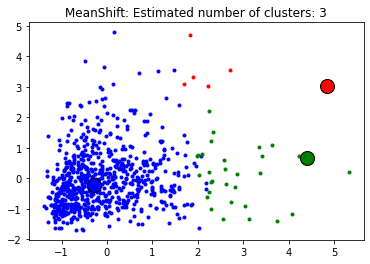

In [42]:
#display mean shift clusters

import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('MeanShift: Estimated number of clusters: %d' % n_clusters_)
plt.show()

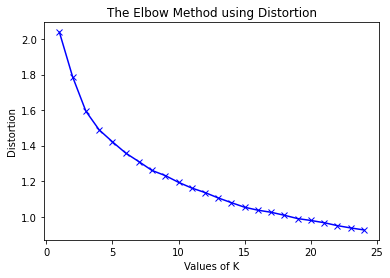

In [8]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 25)

#test for reasonable K
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k,random_state=0)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [9]:
#create cluster using 5 custers

kmeanModel = KMeans(n_clusters=5,random_state=0)
kmeanModel.fit(X)
kmean_df['cluster_group']=kmeanModel.labels_
kmean_df['cluster_type']= "kmeans"

In [10]:
#create agglomerative clusterming model and labels

from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(linkage='ward', n_clusters=4)
aggclust_df['cluster_group'] = model.fit_predict(X)
aggclust_df['cluster_type']= "agglomerative clustering"

In [11]:
#create output csv

union = pd.concat([kmean_df, aggclust_df, meanshift_df], ignore_index=True)
union.to_csv('all_models_output.csv')
